In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from smart_infrastructure.predictive_maintenance import PredictiveMaintenanceSystem

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import joblib
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

class PredictiveMaintenanceSystem:
    """
    A comprehensive system for predictive maintenance of industrial equipment and infrastructure.
    
    This system integrates data preprocessing, feature engineering, model training, 
    and evaluation for predicting equipment failures before they occur.
    """
    
    def __init__(self, data_path=None, model_save_path='models', results_path='results'):
        """
        Initialize the Predictive Maintenance System.
        
        Parameters:
        -----------
        data_path : str
            Path to the dataset
        model_save_path : str
            Directory to save trained models
        results_path : str
            Directory to save results and visualizations
        """
        self.data_path = data_path
        self.model_save_path = model_save_path
        self.results_path = results_path
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {}
        self.best_model = None
        self.preprocessor = None
        
        # Create directories if they don't exist
        for path in [model_save_path, results_path]:
            if not os.path.exists(path):
                os.makedirs(path)
    
    def load_data(self, data_path=None, from_csv=True):
        """
        Load data from a CSV file or a pandas DataFrame.
        
        Parameters:
        -----------
        data_path : str or pandas.DataFrame
            Path to the dataset or a pandas DataFrame
        from_csv : bool
            If True, load data from CSV file, else assume data_path is a DataFrame
            
        Returns:
        --------
        pandas.DataFrame
            The loaded data
        """
        if data_path is not None:
            self.data_path = data_path
            
        if self.data_path is None:
            raise ValueError("No data path provided.")
            
        if from_csv:
            print(f"Loading data from {self.data_path}...")
            self.data = pd.read_csv(self.data_path)
        else:
            print("Using provided DataFrame...")
            self.data = self.data_path
            
        print(f"Data loaded. Shape: {self.data.shape}")
        return self.data
    
    def explore_data(self, save_plots=True):
        """
        Perform exploratory data analysis on the dataset.
        
        Parameters:
        -----------
        save_plots : bool
            If True, save the plots to the results directory
            
        Returns:
        --------
        dict
            A dictionary containing data statistics and information
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        print("Performing exploratory data analysis...")
        
        # Basic information
        data_info = {
            'shape': self.data.shape,
            'columns': self.data.columns.tolist(),
            'dtypes': self.data.dtypes,
            'missing_values': self.data.isnull().sum(),
            'descriptive_stats': self.data.describe()
        }
        
        print(f"Dataset shape: {data_info['shape']}")
        print(f"Missing values:\n{data_info['missing_values']}")
        
        # If target column exists (assuming 'failure' or 'target' column)
        target_col = None
        for col in ['failure', 'target', 'failure_flag', 'failure_status']:
            if col in self.data.columns:
                target_col = col
                break
                
        if target_col:
            print(f"\nTarget column: {target_col}")
            class_distribution = self.data[target_col].value_counts()
            print(f"Class distribution:\n{class_distribution}")
            data_info['target_column'] = target_col
            data_info['class_distribution'] = class_distribution
            
            # Class distribution plot
            plt.figure(figsize=(10, 6))
            sns.countplot(x=target_col, data=self.data)
            plt.title('Class Distribution')
            plt.xlabel(target_col)
            plt.ylabel('Count')
            if save_plots:
                plt.savefig(f"{self.results_path}/class_distribution.png")
                
            # Correlation with target
            if len(self.data.select_dtypes(include=['number']).columns) > 1:
                plt.figure(figsize=(12, 10))
                corr_matrix = self.data.select_dtypes(include=['number']).corr()
                sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
                plt.title('Correlation Matrix')
                if save_plots:
                    plt.savefig(f"{self.results_path}/correlation_matrix.png")
                data_info['correlation_matrix'] = corr_matrix
        
        # For time series data
        time_cols = [col for col in self.data.columns if 'time' in col.lower() or 'date' in col.lower()]
        for col in time_cols:
            if self.data[col].dtype == 'object':
                try:
                    self.data[col] = pd.to_datetime(self.data[col])
                    print(f"Converted {col} to datetime")
                except:
                    print(f"Could not convert {col} to datetime")
        
        # Plot histograms for numerical features
        num_cols = self.data.select_dtypes(include=['number']).columns
        if len(num_cols) > 0:
            plt.figure(figsize=(15, 10))
            self.data[num_cols].hist(bins=20, figsize=(15, 10))
            plt.tight_layout()
            plt.suptitle('Numerical Features Distribution', y=1.02)
            if save_plots:
                plt.savefig(f"{self.results_path}/numerical_histograms.png")
        
        return data_info
    
    def preprocess_data(self, target_col=None, categorical_cols=None, numerical_cols=None, 
                        drop_cols=None, test_size=0.2, random_state=42):
        """
        Preprocess the data for model training.
        
        Parameters:
        -----------
        target_col : str
            Name of the target column
        categorical_cols : list
            List of categorical column names
        numerical_cols : list
            List of numerical column names
        drop_cols : list
            List of columns to drop
        test_size : float
            Proportion of data to use for testing
        random_state : int
            Random seed for reproducibility
            
        Returns:
        --------
        tuple
            Preprocessed (X_train, X_test, y_train, y_test)
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        print("Preprocessing data...")
        
        data = self.data.copy()
        
        # If target column is not specified, try to infer
        if target_col is None:
            for col in ['failure', 'target', 'failure_flag', 'failure_status']:
                if col in data.columns:
                    target_col = col
                    break
            if target_col is None:
                raise ValueError("Target column not specified and could not be inferred.")
        
        # Automatically identify column types if not specified
        if categorical_cols is None:
            categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
            if target_col in categorical_cols:
                categorical_cols.remove(target_col)
                
        if numerical_cols is None:
            numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
            if target_col in numerical_cols:
                numerical_cols.remove(target_col)
                
        # Drop specified columns
        if drop_cols:
            data = data.drop(columns=drop_cols)
            categorical_cols = [col for col in categorical_cols if col not in drop_cols]
            numerical_cols = [col for col in numerical_cols if col not in drop_cols]
            
        print(f"Target column: {target_col}")
        print(f"Categorical columns: {categorical_cols}")
        print(f"Numerical columns: {numerical_cols}")
        
        # Handle datetime columns
        datetime_cols = []
        for col in data.columns:
            if data[col].dtype == 'datetime64[ns]':
                datetime_cols.append(col)
                # Extract useful features from datetime
                data[f'{col}_year'] = data[col].dt.year
                data[f'{col}_month'] = data[col].dt.month
                data[f'{col}_day'] = data[col].dt.day
                data[f'{col}_hour'] = data[col].dt.hour
                data[f'{col}_dayofweek'] = data[col].dt.dayofweek
                
                # Add these new columns to numerical columns
                numerical_cols.extend([f'{col}_year', f'{col}_month', f'{col}_day', 
                                     f'{col}_hour', f'{col}_dayofweek'])
                
        # Drop original datetime columns
        if datetime_cols:
            data = data.drop(columns=datetime_cols)
            
        # Split into features and target
        X = data.drop(columns=[target_col])
        y = data[target_col]
        
        # Split into train and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y if y.nunique() < 10 else None
        )
        
        print(f"Train set: {self.X_train.shape}")
        print(f"Test set: {self.X_test.shape}")
        
        # Create preprocessing pipeline
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])
        
        # Fit and transform the training data
        self.X_train_processed = self.preprocessor.fit_transform(self.X_train)
        self.X_test_processed = self.preprocessor.transform(self.X_test)
        
        print(f"Processed train set: {self.X_train_processed.shape}")
        print(f"Processed test set: {self.X_test_processed.shape}")
        
        return self.X_train_processed, self.X_test_processed, self.y_train, self.y_test
    
    def train_models(self, models_to_train=None, param_grids=None):
        """
        Train multiple models and find the best performing one.
        
        Parameters:
        -----------
        models_to_train : list
            List of model names to train ('rf', 'gb', 'xgb')
        param_grids : dict
            Dictionary of parameter grids for each model
            
        Returns:
        --------
        dict
            Dictionary of trained models
        """
        if self.X_train_processed is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
            
        if models_to_train is None:
            models_to_train = ['rf', 'gb', 'xgb']
            
        # Default parameter grids
        if param_grids is None:
            param_grids = {
                'rf': {
                    'n_estimators': [100, 200],
                    'max_depth': [None, 10, 20],
                    'min_samples_split': [2, 5],
                    'min_samples_leaf': [1, 2]
                },
                'gb': {
                    'n_estimators': [100, 200],
                    'learning_rate': [0.01, 0.1],
                    'max_depth': [3, 5]
                },
                'xgb': {
                    'n_estimators': [100, 200],
                    'learning_rate': [0.01, 0.1],
                    'max_depth': [3, 5]
                }
            }
            
        print("Training models...")
        
        # Dictionary to store model results
        model_results = {}
        
        # Train each model
        for model_name in models_to_train:
            print(f"\nTraining {model_name}...")
            
            if model_name == 'rf':
                model = RandomForestClassifier(random_state=42)
                param_grid = param_grids.get('rf')
            elif model_name == 'gb':
                model = GradientBoostingClassifier(random_state=42)
                param_grid = param_grids.get('gb')
            elif model_name == 'xgb':
                model = xgb.XGBClassifier(random_state=42)
                param_grid = param_grids.get('xgb')
            else:
                print(f"Unknown model: {model_name}")
                continue
                
            # Perform grid search with cross-validation
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=5,
                scoring='f1',
                n_jobs=-1,
                verbose=1
            )
            
            grid_search.fit(self.X_train_processed, self.y_train)
            
            # Get the best model
            best_model = grid_search.best_estimator_
            
            # Make predictions
            y_pred = best_model.predict(self.X_test_processed)
            
            # Calculate metrics
            if len(np.unique(self.y_test)) <= 2:  # Binary classification
                y_pred_proba = best_model.predict_proba(self.X_test_processed)[:, 1]
                roc_auc = roc_auc_score(self.y_test, y_pred_proba)
            else:
                roc_auc = None
                
            model_metrics = {
                'accuracy': accuracy_score(self.y_test, y_pred),
                'precision': precision_score(self.y_test, y_pred, average='weighted'),
                'recall': recall_score(self.y_test, y_pred, average='weighted'),
                'f1': f1_score(self.y_test, y_pred, average='weighted'),
                'roc_auc': roc_auc,
                'best_params': grid_search.best_params_,
                'confusion_matrix': confusion_matrix(self.y_test, y_pred),
                'classification_report': classification_report(self.y_test, y_pred)
            }
            
            # Store model and results
            self.models[model_name] = {
                'model': best_model,
                'metrics': model_metrics
            }
            
            # Print results
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Accuracy: {model_metrics['accuracy']:.4f}")
            print(f"F1 Score: {model_metrics['f1']:.4f}")
            if roc_auc:
                print(f"ROC AUC: {model_metrics['roc_auc']:.4f}")
            print(f"Classification Report:\n{model_metrics['classification_report']}")
            
            # Save model
            model_filename = f"{self.model_save_path}/{model_name}_model.joblib"
            joblib.dump(best_model, model_filename)
            print(f"Model saved to {model_filename}")
            
            # Plot confusion matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(model_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - {model_name.upper()}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.savefig(f"{self.results_path}/{model_name}_confusion_matrix.png")
            
            # Plot ROC curve for binary classification
            if roc_auc:
                plt.figure(figsize=(10, 8))
                fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
                plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], 'k--', lw=2)
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve - {model_name.upper()}')
                plt.legend(loc="lower right")
                plt.savefig(f"{self.results_path}/{model_name}_roc_curve.png")
            
        # Find the best model based on F1 score
        best_model_name = max(self.models, key=lambda x: self.models[x]['metrics']['f1'])
        self.best_model = self.models[best_model_name]
        
        print(f"\nBest model: {best_model_name.upper()} with F1 score: {self.best_model['metrics']['f1']:.4f}")
        
        return self.models
    
    def analyze_feature_importance(self, model_name=None, top_n=20):
        """
        Analyze and visualize feature importance.
        
        Parameters:
        -----------
        model_name : str
            Name of the model to analyze ('rf', 'gb', 'xgb'). If None, use the best model.
        top_n : int
            Number of top features to show
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with feature importance scores
        """
        if not self.models:
            raise ValueError("No models trained. Call train_models() first.")
            
        if model_name is None:
            model_name = max(self.models, key=lambda x: self.models[x]['metrics']['f1'])
            
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not found. Available models: {list(self.models.keys())}")
            
        model = self.models[model_name]['model']
        
        # Get feature names
        feature_names = []
        
        # For numerical features
        for name, _, cols in self.preprocessor.transformers_:
            if name == 'num':
                feature_names.extend(cols)
            elif name == 'cat':
                # For categorical features, get the one-hot encoded column names
                ohe = self.preprocessor.named_transformers_['cat'].named_steps['onehot']
                for i, col in enumerate(cols):
                    categories = ohe.categories_[i]
                    feature_names.extend([f"{col}_{cat}" for cat in categories])
        
        # Get feature importances
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            raise ValueError(f"Model {model_name} does not have feature_importances_ attribute")
            
        # Create DataFrame with feature importances
        feature_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Plot top N feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=feature_imp.head(top_n))
        plt.title(f'Top {top_n} Feature Importances - {model_name.upper()}')
        plt.tight_layout()
        plt.savefig(f"{self.results_path}/{model_name}_feature_importance.png")
        
        return feature_imp
    
    def predict(self, new_data, model_name=None, threshold=0.5):
        """
        Make predictions on new data.
        
        Parameters:
        -----------
        new_data : pandas.DataFrame
            New data to make predictions on
        model_name : str
            Name of the model to use for prediction. If None, use the best model.
        threshold : float
            Probability threshold for binary classification
            
        Returns:
        --------
        numpy.ndarray
            Predictions
        """
        if not self.models:
            raise ValueError("No models trained. Call train_models() first.")
            
        if model_name is None and self.best_model:
            model = self.best_model['model']
        elif model_name in self.models:
            model = self.models[model_name]['model']
        else:
            raise ValueError(f"Model {model_name} not found and no best model available.")
            
        # Preprocess the new data
        new_data_processed = self.preprocessor.transform(new_data)
        
        # Make predictions
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(new_data_processed)
            
            if probabilities.shape[1] == 2:  # Binary classification
                # Apply threshold for binary classification
                predictions = (probabilities[:, 1] >= threshold).astype(int)
                pred_probabilities = probabilities[:, 1]
            else:  # Multiclass classification
                predictions = model.predict(new_data_processed)
                pred_probabilities = np.max(probabilities, axis=1)
        else:
            predictions = model.predict(new_data_processed)
            pred_probabilities = None
            
        return predictions, pred_probabilities
    
    def evaluate_model_over_time(self, time_col, freq='M', rolling_window=3):
        """
        Evaluate model performance over time periods.
        
        Parameters:
        -----------
        time_col : str
            Column name containing timestamps
        freq : str
            Frequency for time grouping ('D' for day, 'W' for week, 'M' for month)
        rolling_window : int
            Size of the rolling window for smoother metrics
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with performance metrics over time
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        if self.best_model is None:
            raise ValueError("No models trained. Call train_models() first.")
            
        # Convert to datetime if needed
        if self.data[time_col].dtype != 'datetime64[ns]':
            try:
                self.data[time_col] = pd.to_datetime(self.data[time_col])
            except:
                raise ValueError(f"Could not convert {time_col} to datetime")
                
        # Sort by time
        data_sorted = self.data.sort_values(time_col)
        
        # Identify target column
        target_col = None
        for col in ['failure', 'target', 'failure_flag', 'failure_status']:
            if col in self.data.columns:
                target_col = col
                break
                
        if target_col is None:
            raise ValueError("Target column not found")
            
        # Group by time period
        data_sorted['time_group'] = data_sorted[time_col].dt.to_period(freq)
        
        # Evaluate performance for each time group
        time_metrics = []
        
        for period, group in data_sorted.groupby('time_group'):
            # Skip groups without both classes (if binary)
            if group[target_col].nunique() < 2:
                continue
                
            # Preprocess group data
            X_group = group.drop(columns=[target_col, time_col, 'time_group'])
            y_group = group[target_col]
            
            # Apply preprocessing
            X_group_processed = self.preprocessor.transform(X_group)
            
            # Get predictions
            y_pred = self.best_model['model'].predict(X_group_processed)
            
            # Calculate metrics
            metrics = {
                'period': period.strftime('%Y-%m'),
                'accuracy': accuracy_score(y_group, y_pred),
                'precision': precision_score(y_group, y_pred, average='weighted'),
                'recall': recall_score(y_group, y_pred, average='weighted'),
                'f1': f1_score(y_group, y_pred, average='weighted'),
                'samples': len(group)
            }
            
            time_metrics.append(metrics)
            
        # Convert to DataFrame
        time_metrics_df = pd.DataFrame(time_metrics)
        
        # Calculate rolling averages for smoother metrics
        if len(time_metrics_df) > rolling_window:
            for metric in ['accuracy', 'precision', 'recall', 'f1']:
                time_metrics_df[f'{metric}_rolling'] = time_metrics_df[metric].rolling(window=rolling_window).mean()
        
        # Plot metrics over time
        plt.figure(figsize=(12, 8))
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
        
        for metric in metrics_to_plot:
            if f'{metric}_rolling' in time_metrics_df.columns:
                plt.plot(time_metrics_df['period'], time_metrics_df[f'{metric}_rolling'], marker='o', label=f'{metric.capitalize()} (Rolling)')
            else:
                plt.plot(time_metrics_df['period'], time_metrics_df[metric], marker='o', label=metric.capitalize())
                
        plt.title('Model Performance Over Time')
        plt.xlabel('Time Period')
        plt.ylabel('Metric Value')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"{self.results_path}/performance_over_time.png")
        
        return time_metrics_df
    
    def create_maintenance_schedule(self, new_data, time_col, id_col, model_name=None, 
                                   risk_threshold=0.7, lead_time_days=7):
        """
        Create a maintenance schedule based on failure predictions.
        
        Parameters:
        -----------
        new_data : pandas.DataFrame
            New data to make predictions on
        time_col : str
            Column name containing timestamps
        id_col : str
            Column name containing equipment IDs
        model_name : str
            Name of the model to use for prediction. If None, use the best model.
        risk_threshold : float
            Probability threshold above which maintenance is recommended
        lead_time_days : int
            Number of days in advance to schedule maintenance
            
        Returns:
        --------
        pandas.DataFrame
            Maintenance schedule with equipment IDs, risk scores, and recommended dates
        """
        # Get predictions and probabilities
        predictions, probabilities = self.predict(new_data, model_name=model_name)
        
        # Convert timestamp column to datetime if needed
        if new_data[time_col].dtype != 'datetime64[ns]':
            new_data[time_col] = pd.to_datetime(new_data[time_col])
            
        # Create maintenance schedule DataFrame
        maintenance_df = pd.DataFrame({
            'equipment_id': new_data[id_col],
            'last_reading_date': new_data[time_col],
            'failure_probability': probabilities,
            'failure_predicted': predictions
        })
        
        # Calculate recommended maintenance date
        today = datetime.datetime.now()
        maintenance_df['days_since_reading'] = (today - maintenance_df['last_reading_date']).dt.days
        
        # Add lead time for scheduling
        maintenance_df['recommended_maintenance_date'] = np.where(
            maintenance_df['failure_probability'] >= risk_threshold,
            today + pd.Timedelta(days=lead_time_days),
            pd.NaT
        )
        
        # Create risk categories
        maintenance_df['risk_category'] = pd.cut(
            maintenance_df['failure_probability'],
            bins=[0, 0.25, 0.5, 0.75, 1.0],
            labels=['Low', 'Medium', 'High', 'Critical']
        )
        
        # Sort by risk probability (highest first)
        maintenance_df = maintenance_df.sort_values('failure_probability', ascending=False).reset_index(drop=True)
        
        # Save maintenance schedule
        maintenance_df.to_csv(f"{self.results_path}/maintenance_schedule.csv", index=False)
        
        # Create visualization of equipment by risk category
        plt.figure(figsize=(12, 6))
        risk_counts = maintenance_df['risk_category'].value_counts().sort_index()
        colors = ['green', 'yellow', 'orange', 'red']
        ax = risk_counts.plot(kind='bar', color=colors)
        plt.title('Equipment by Risk Category')
        plt.xlabel('Risk Category')
        plt.ylabel('Count')
        
        # Add count labels on bars
        for i, count in enumerate(risk_counts):
            ax.annotate(str(count), xy=(i, count), ha='center', va='bottom')
            
        plt.tight_layout()
        plt.savefig(f"{self.results_path}/risk_categories.png")
        
        return maintenance_df
    
    def save_system(self, filename='predictive_maintenance_system.joblib'):
        """
        Save the entire predictive maintenance system for later use.
        
        Parameters:
        -----------
        filename : str
            Filename to save the system
            
        Returns:
        --------
        str
            Path to the saved file
        """
        system_state = {
            'preprocessor': self.preprocessor,
            'models': {name: model['model'] for name, model in self.models.items()},
            'model_metrics': {name: model['metrics'] for name, model in self.models.items()},
            'best_model_name': max(self.models, key=lambda x: self.models[x]['metrics']['f1']) if self.models else None
        }
        
        save_path = f"{self.model_save_path}/{filename}"
        joblib.dump(system_state, save_path)
        print(f"System saved to {save_path}")
        
        return save_path
    
    @classmethod
    def load_system(cls, filepath, data_path=None):
        """
        Load a previously saved predictive maintenance system.
        
        Parameters:
        -----------
        filepath : str
            Path to saved system file
        data_path : str
            Path to data (optional)
            
        Returns:
        --------
        PredictiveMaintenanceSystem
            Loaded system
        """
        system_state = joblib.load(filepath)
        
        # Create new instance
        loaded_system = cls(data_path=data_path)
        
        # Restore state
        loaded_system.preprocessor = system_state['preprocessor']
        
        # Rebuild models dictionary
        loaded_system.models = {}
        for name, model in system_state['models'].items():
            loaded_system.models[name] = {
                'model': model,
                'metrics': system_state['model_metrics'][name]
            }
            
        # Set best model
        if system_state['best_model_name']:
            loaded_system.best_model = loaded_system.models[system_state['best_model_name']]
            
        print(f"System loaded from {filepath}")
        return loaded_system
    
    def deployment_dashboard(self, threshold=0.5, return_html=False):
        """
        Create an HTML dashboard for model deployment monitoring.
        
        Parameters:
        -----------
        threshold : float
            Risk threshold for failure prediction
        return_html : bool
            If True, return HTML string instead of saving to file
            
        Returns:
        --------
        str
            Path to the saved dashboard HTML file or HTML string
        """
        if not self.models:
            raise ValueError("No models trained. Call train_models() first.")
            
        # Get best model info
        best_model_name = max(self.models, key=lambda x: self.models[x]['metrics']['f1'])
        best_model_metrics = self.models[best_model_name]['metrics']
        
        # Create HTML content
        html = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Predictive Maintenance Dashboard</title>
            <style>
                body {{
                    font-family: Arial, sans-serif;
                    margin: 0;
                    padding: 20px;
                    background-color: #f5f5f5;
                }}
                .container {{
                    max-width: 1200px;
                    margin: 0 auto;
                }}
                .header {{
                    background-color: #3498db;
                    color: white;
                    padding: 20px;
                    text-align: center;
                    border-radius: 5px 5px 0 0;
                }}
                .metrics-container {{
                    display: flex;
                    justify-content: space-between;
                    margin-top: 20px;
                }}
                .metric-card {{
                    background-color: white;
                    border-radius: 5px;
                    box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1);
                    padding: 20px;
                    flex: 1;
                    margin: 0 10px;
                    text-align: center;
                }}
                .metric-value {{
                    font-size: 24px;
                    font-weight: bold;
                    margin: 10px 0;
                }}
                .widget-container {{
                    background-color: white;
                    border-radius: 5px;
                    box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1);
                    padding: 20px;
                    margin-top: 20px;
                }}
                table {{
                    width: 100%;
                    border-collapse: collapse;
                    margin-top: 20px;
                }}
                th, td {{
                    border: 1px solid #ddd;
                    padding: 12px;
                    text-align: left;
                }}
                th {{
                    background-color: #f2f2f2;
                }}
                tr:nth-child(even) {{
                    background-color: #f9f9f9;
                }}
                .status-indicator {{
                    display: inline-block;
                    width: 15px;
                    height: 15px;
                    border-radius: 50%;
                    margin-right: 5px;
                }}
                .status-active {{
                    background-color: #2ecc71;
                }}
                .footer {{
                    margin-top: 30px;
                    text-align: center;
                    color: #7f8c8d;
                    font-size: 14px;
                }}
            </style>
        </head>
        <body>
            <div class="container">
                <div class="header">
                    <h1>Predictive Maintenance System Dashboard</h1>
                    <p>Smart Infrastructure Monitoring</p>
                </div>
                
                <div class="metrics-container">
                    <div class="metric-card">
                        <h3>Accuracy</h3>
                        <div class="metric-value">{best_model_metrics['accuracy']:.2%}</div>
                    </div>
                    <div class="metric-card">
                        <h3>Precision</h3>
                        <div class="metric-value">{best_model_metrics['precision']:.2%}</div>
                    </div>
                    <div class="metric-card">
                        <h3>Recall</h3>
                        <div class="metric-value">{best_model_metrics['recall']:.2%}</div>
                    </div>
                    <div class="metric-card">
                        <h3>F1 Score</h3>
                        <div class="metric-value">{best_model_metrics['f1']:.2%}</div>
                    </div>
                </div>
                
                <div class="widget-container">
                    <h2>Model Deployment Information</h2>
                    <table>
                        <tr>
                            <th>Model Type</th>
                            <td>{best_model_name.upper()}</td>
                        </tr>
                        <tr>
                            <th>Deployment Status</th>
                            <td><span class="status-indicator status-active"></span> Active</td>
                        </tr>
                        <tr>
                            <th>Risk Threshold</th>
                            <td>{threshold}</td>
                        </tr>
                        <tr>
                            <th>Last Updated</th>
                            <td>{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</td>
                        </tr>
                        <tr>
                            <th>Best Parameters</th>
                            <td>{str(best_model_metrics['best_params'])}</td>
                        </tr>
                    </table>
                </div>
                
                <div class="widget-container">
                    <h2>Classification Report</h2>
                    <pre>{best_model_metrics['classification_report']}</pre>
                </div>
                
                <div class="footer">
                    <p>Predictive Maintenance System v1.0 | Generated on {datetime.datetime.now().strftime('%Y-%m-%d')}</p>
                </div>
            </div>
        </body>
        </html>
        """
        
        if return_html:
            return html
            
        # Save to file
        dashboard_path = f"{self.results_path}/deployment_dashboard.html"
        with open(dashboard_path, 'w') as f:
            f.write(html)
            
        print(f"Dashboard saved to {dashboard_path}")
        return dashboard_path

def generate_synthetic_data(n_samples=1000, n_equipment=50, start_date='2022-01-01', end_date='2023-01-01'):
    """
    Generate synthetic data for predictive maintenance example.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    n_equipment : int
        Number of unique equipment IDs
    start_date : str
        Start date for data generation
    end_date : str
        End date for data generation
        
    Returns:
    --------
    pandas.DataFrame
        Synthetic dataset
    """
    # Generate equipment IDs
    equipment_ids = [f"EQ{i:03d}" for i in range(1, n_equipment + 1)]
    
    # Generate timestamps
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    dates = pd.date_range(start=start, end=end, periods=n_samples)
    
    # Initialize data dictionary
    data = {
        'timestamp': np.random.choice(dates, n_samples),
        'equipment_id': np.random.choice(equipment_ids, n_samples),
        'sensor_temp': np.random.normal(65, 15, n_samples),
        'sensor_pressure': np.random.normal(100, 20, n_samples),
        'sensor_vibration': np.random.normal(0.5, 0.2, n_samples),
        'sensor_rotation': np.random.normal(1000, 200, n_samples),
        'sensor_voltage': np.random.normal(220, 30, n_samples),
        'sensor_current': np.random.normal(50, 10, n_samples),
        'operational_hours': np.random.randint(0, 24, n_samples),
        'maintenance_since_days': np.random.randint(0, 365, n_samples),
        'equipment_age_years': np.random.uniform(0, 10, n_samples)
    }
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    # Sort by timestamp
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # Generate the target variable (failure)
    # Higher probability of failure when:
    # - Temperature is high
    # - Vibration is high
    # - Equipment age is high
    # - Days since maintenance is high
    
    # Normalize features for the failure probability calculation
    temp_norm = (df['sensor_temp'] - df['sensor_temp'].min()) / (df['sensor_temp'].max() - df['sensor_temp'].min())
    vib_norm = (df['sensor_vibration'] - df['sensor_vibration'].min()) / (df['sensor_vibration'].max() - df['sensor_vibration'].min())
    age_norm = df['equipment_age_years'] / 10
    maint_norm = df['maintenance_since_days'] / 365
    
    # Calculate failure probability
    failure_prob = 0.3 * temp_norm + 0.3 * vib_norm + 0.2 * age_norm + 0.2 * maint_norm
    
    # Add some randomness
    failure_prob = failure_prob + np.random.normal(0, 0.1, n_samples)
    failure_prob = np.clip(failure_prob, 0, 1)
    
    # Generate binary failure indicator (1 = failure, 0 = no failure)
    df['failure'] = (failure_prob > 0.7).astype(int)
    
    # Add equipment type
    equipment_types = ['Pump', 'Motor', 'Valve', 'Compressor', 'Generator']
    df['equipment_type'] = np.random.choice(equipment_types, n_samples)
    
    # Add location
    locations = ['Building A', 'Building B', 'Building C', 'Outdoor', 'Basement']
    df['location'] = np.random.choice(locations, n_samples)
    
    # Add weather condition
    weather_conditions = ['Normal', 'Hot', 'Cold', 'Humid', 'Dry']
    df['weather_condition'] = np.random.choice(weather_conditions, n_samples)
    
    return df

def main():
    """
    Main function to demonstrate the Predictive Maintenance System.
    """
    print("Generating synthetic data for predictive maintenance example...\n")
    
    # Generate synthetic data
    data = generate_synthetic_data(n_samples=10000, n_equipment=100)
    
    # Save data to CSV for later use
    data.to_csv("data/maintenance_data.csv", index=False)
    print(f"Data generated and saved to data/maintenance_data.csv")
    print(f"Shape: {data.shape}")
    print(f"Failure rate: {data['failure'].mean():.2%}\n")
    
    # Initialize the predictive maintenance system
    print("Initializing the predictive maintenance system...\n")
    maintenance_system = PredictiveMaintenanceSystem(data_path=data, 
                                                    model_save_path='models', 
                                                    results_path='results')
    
    # Explore the data
    print("Exploring the data...\n")
    data_info = maintenance_system.explore_data(save_plots=True)
    
    # Preprocess the data
    print("\nPreprocessing the data...\n")
    categorical_cols = ['equipment_id', 'equipment_type', 'location', 'weather_condition']
    numerical_cols = ['sensor_temp', 'sensor_pressure', 'sensor_vibration', 'sensor_rotation',
                      'sensor_voltage', 'sensor_current', 'operational_hours', 
                      'maintenance_since_days', 'equipment_age_years']
    
    X_train, X_test, y_train, y_test = maintenance_system.preprocess_data(
        target_col='failure',
        categorical_cols=categorical_cols,
        numerical_cols=numerical_cols,
        drop_cols=['timestamp']  # We'll extract time features
    )
    
    # Train models
    print("\nTraining models...\n")
    
    # Define smaller parameter grids for demonstration
    param_grids = {
        'rf': {
            'n_estimators': [100],
            'max_depth': [10],
            'min_samples_split': [5]
        },
        'xgb': {
            'n_estimators': [100],
            'learning_rate': [0.1],
            'max_depth': [5]
        }
    }
    
    models = maintenance_system.train_models(models_to_train=['rf', 'xgb'], param_grids=param_grids)
    
    # Analyze feature importance
    print("\nAnalyzing feature importance...\n")
    feature_imp = maintenance_system.analyze_feature_importance(top_n=15)
    print("\nTop 10 features:")
    print(feature_imp.head(10))
    
    # Evaluate model over time
    print("\nEvaluating model performance over time...\n")
    time_metrics = maintenance_system.evaluate_model_over_time(time_col='timestamp', freq='M')
    
    # Generate some new data for prediction
    print("\nGenerating new data for predictions...\n")
    new_data = generate_synthetic_data(n_samples=500, n_equipment=20, 
                                       start_date='2023-01-01', end_date='2023-02-01')
    
    # Create maintenance schedule
    print("\nCreating maintenance schedule...\n")
    maintenance_schedule = maintenance_system.create_maintenance_schedule(
        new_data=new_data,
        time_col='timestamp',
        id_col='equipment_id',
        risk_threshold=0.6,
        lead_time_days=5
    )
    
    print("\nMaintenance schedule (top 10 highest risk):")
    print(maintenance_schedule[['equipment_id', 'failure_probability', 
                               'risk_category', 'recommended_maintenance_date']].head(10))
    
    # Save the system for later use
    print("\nSaving the predictive maintenance system...\n")
    system_path = maintenance_system.save_system()
    
    # Create deployment dashboard
    print("\nCreating deployment dashboard...\n")
    dashboard_path = maintenance_system.deployment_dashboard()
    print(f"Dashboard created at: {dashboard_path}")
    
    print("\nDone! The predictive maintenance system is ready for use.")
    
if __name__ == "__main__":
    # Create directories if they don't exist
    import os
    for directory in ['data', 'models', 'results']:
        if not os.path.exists(directory):
            os.makedirs(directory)
    
    main()

ModuleNotFoundError: No module named 'smart_infrastructure'

Setting up the predictive maintenance system...

Loaded existing data from data/maintenance_data.csv
Shape: (5000, 15)
Failure rate: 2.12%

Initializing the predictive maintenance system...

Using provided DataFrame...
Data loaded. Shape: (5000, 15)
Exploring the data...

Performing exploratory data analysis...
Dataset shape: (5000, 15)
Missing values:
timestamp                 0
equipment_id              0
equipment_age_years       0
equipment_type            0
location                  0
maintenance_since_days    0
operational_hours         0
weather_condition         0
sensor_temp               0
sensor_pressure           0
sensor_vibration          0
sensor_rotation           0
sensor_voltage            0
sensor_current            0
failure                   0
dtype: int64

Target column: failure
Class distribution:
0    4894
1     106
Name: failure, dtype: int64
Converted timestamp to datetime

Preprocessing the data...

Preprocessing data...
Target column: failure
Categorical col

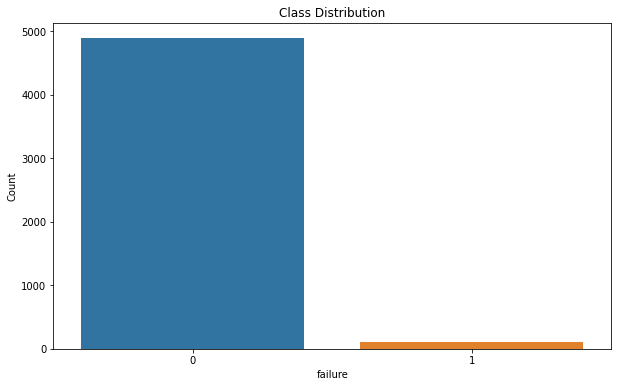

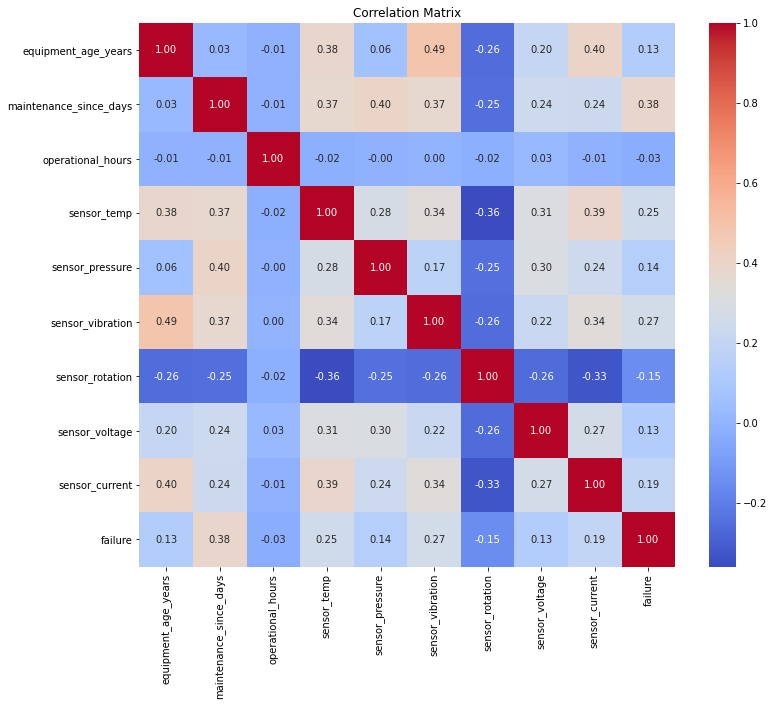

<Figure size 1080x720 with 0 Axes>

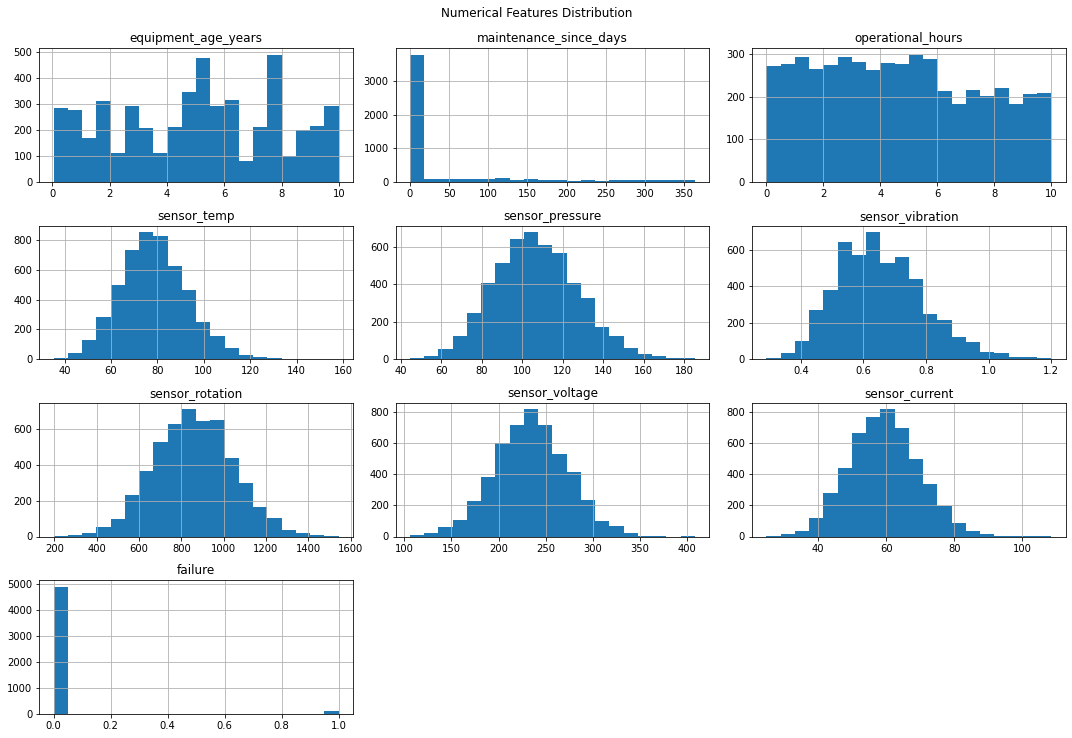

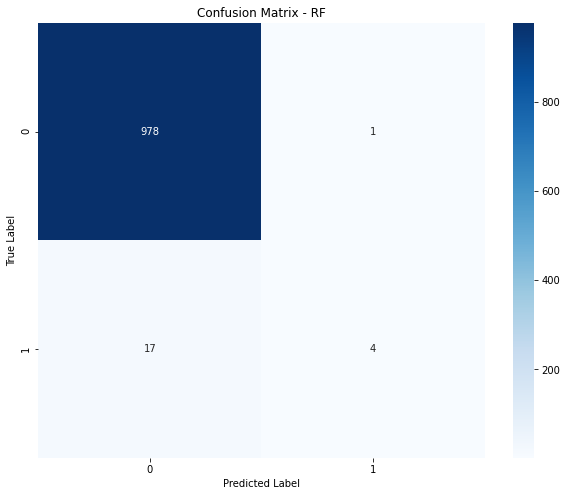

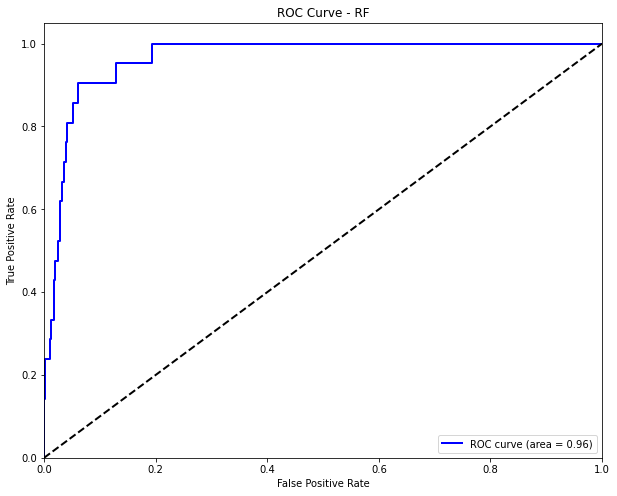

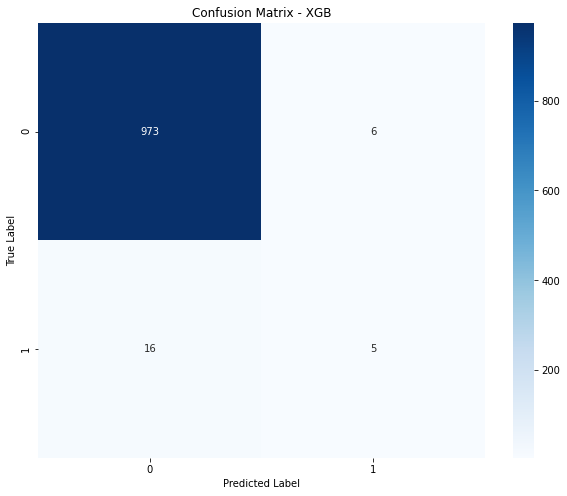

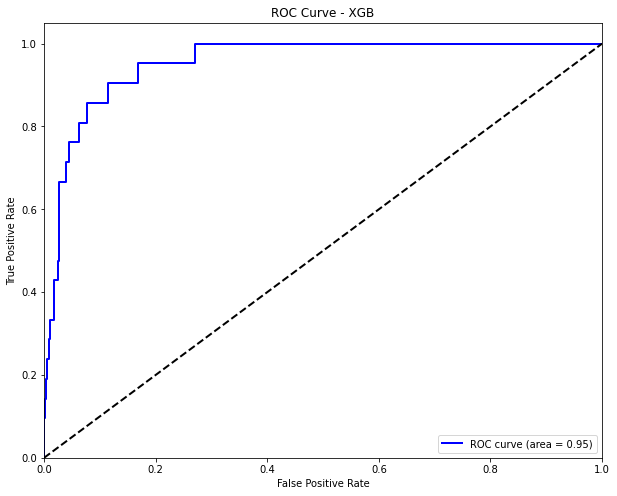

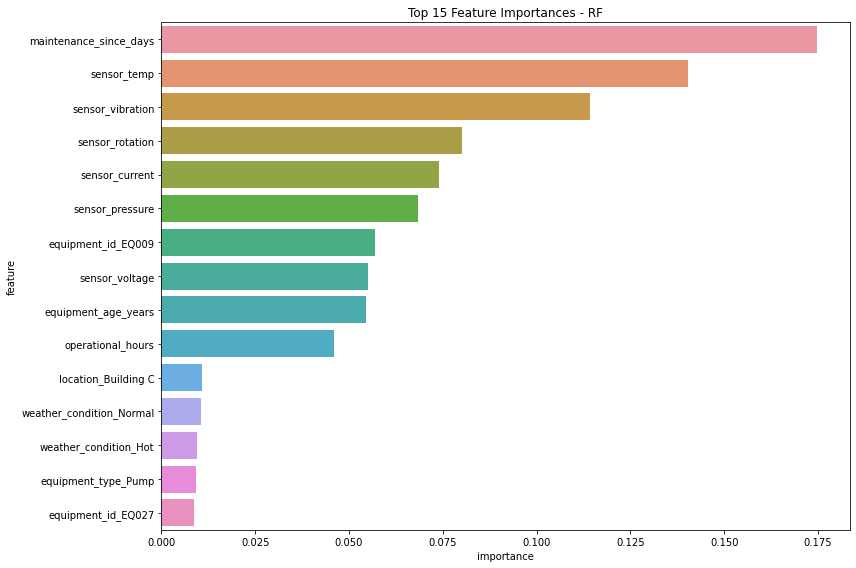

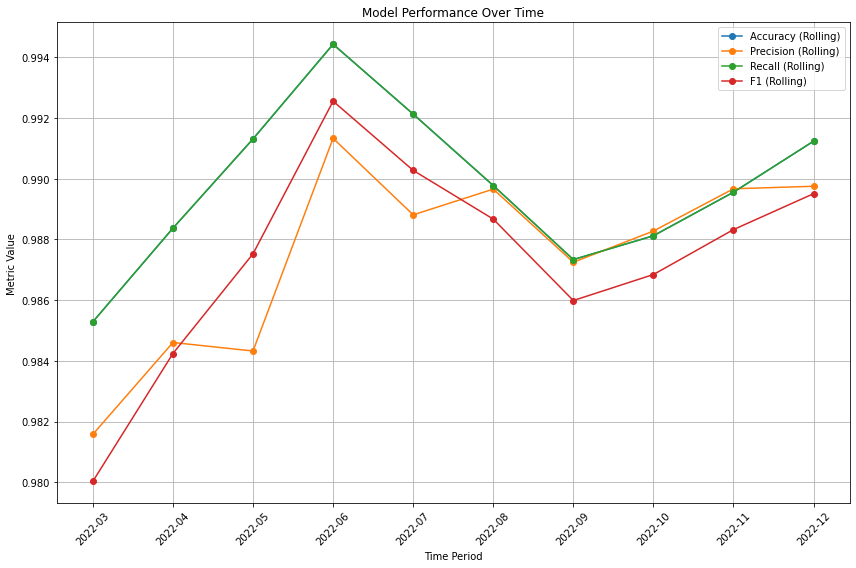

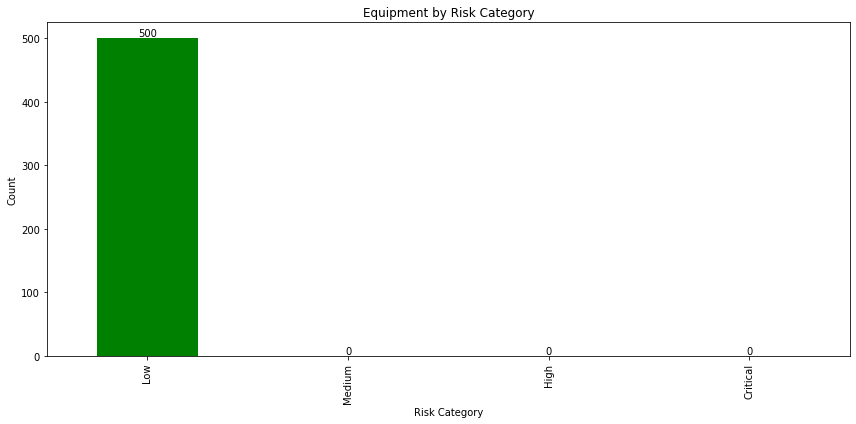

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
# Import statements for PredictiveMaintenanceSystem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import joblib
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

class PredictiveMaintenanceSystem:
    """
    A comprehensive system for predictive maintenance of industrial equipment and infrastructure.
    
    This system integrates data preprocessing, feature engineering, model training, 
    and evaluation for predicting equipment failures before they occur.
    """
    
    def __init__(self, data_path=None, model_save_path='models', results_path='results'):
        """
        Initialize the Predictive Maintenance System.
        
        Parameters:
        -----------
        data_path : str
            Path to the dataset
        model_save_path : str
            Directory to save trained models
        results_path : str
            Directory to save results and visualizations
        """
        self.data_path = data_path
        self.model_save_path = model_save_path
        self.results_path = results_path
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {}
        self.best_model = None
        self.preprocessor = None
        
        # Create directories if they don't exist
        for path in [model_save_path, results_path]:
            if not os.path.exists(path):
                os.makedirs(path)
    
    def load_data(self, data_path=None, from_csv=True):
        """
        Load data from a CSV file or a pandas DataFrame.
        
        Parameters:
        -----------
        data_path : str or pandas.DataFrame
            Path to the dataset or a pandas DataFrame
        from_csv : bool
            If True, load data from CSV file, else assume data_path is a DataFrame
            
        Returns:
        --------
        pandas.DataFrame
            The loaded data
        """
        if data_path is not None:
            self.data_path = data_path
            
        if self.data_path is None:
            raise ValueError("No data path provided.")
            
        if from_csv:
            print(f"Loading data from {self.data_path}...")
            self.data = pd.read_csv(self.data_path)
        else:
            print("Using provided DataFrame...")
            self.data = self.data_path
            
        print(f"Data loaded. Shape: {self.data.shape}")
        return self.data
    
    def explore_data(self, save_plots=True):
        """
        Perform exploratory data analysis on the dataset.
        
        Parameters:
        -----------
        save_plots : bool
            If True, save the plots to the results directory
            
        Returns:
        --------
        dict
            A dictionary containing data statistics and information
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        print("Performing exploratory data analysis...")
        
        # Basic information
        data_info = {
            'shape': self.data.shape,
            'columns': self.data.columns.tolist(),
            'dtypes': self.data.dtypes,
            'missing_values': self.data.isnull().sum(),
            'descriptive_stats': self.data.describe()
        }
        
        print(f"Dataset shape: {data_info['shape']}")
        print(f"Missing values:\n{data_info['missing_values']}")
        
        # If target column exists (assuming 'failure' or 'target' column)
        target_col = None
        for col in ['failure', 'target', 'failure_flag', 'failure_status']:
            if col in self.data.columns:
                target_col = col
                break
                
        if target_col:
            print(f"\nTarget column: {target_col}")
            class_distribution = self.data[target_col].value_counts()
            print(f"Class distribution:\n{class_distribution}")
            data_info['target_column'] = target_col
            data_info['class_distribution'] = class_distribution
            
            # Class distribution plot
            plt.figure(figsize=(10, 6))
            sns.countplot(x=target_col, data=self.data)
            plt.title('Class Distribution')
            plt.xlabel(target_col)
            plt.ylabel('Count')
            if save_plots:
                plt.savefig(f"{self.results_path}/class_distribution.png")
                
            # Correlation with target
            if len(self.data.select_dtypes(include=['number']).columns) > 1:
                plt.figure(figsize=(12, 10))
                corr_matrix = self.data.select_dtypes(include=['number']).corr()
                sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
                plt.title('Correlation Matrix')
                if save_plots:
                    plt.savefig(f"{self.results_path}/correlation_matrix.png")
                data_info['correlation_matrix'] = corr_matrix
        
        # For time series data
        time_cols = [col for col in self.data.columns if 'time' in col.lower() or 'date' in col.lower()]
        for col in time_cols:
            if self.data[col].dtype == 'object':
                try:
                    self.data[col] = pd.to_datetime(self.data[col])
                    print(f"Converted {col} to datetime")
                except:
                    print(f"Could not convert {col} to datetime")
        
        # Plot histograms for numerical features
        num_cols = self.data.select_dtypes(include=['number']).columns
        if len(num_cols) > 0:
            plt.figure(figsize=(15, 10))
            self.data[num_cols].hist(bins=20, figsize=(15, 10))
            plt.tight_layout()
            plt.suptitle('Numerical Features Distribution', y=1.02)
            if save_plots:
                plt.savefig(f"{self.results_path}/numerical_histograms.png")
        
        return data_info
    
    def preprocess_data(self, target_col=None, categorical_cols=None, numerical_cols=None, 
                        drop_cols=None, test_size=0.2, random_state=42):
        """
        Preprocess the data for model training.
        
        Parameters:
        -----------
        target_col : str
            Name of the target column
        categorical_cols : list
            List of categorical column names
        numerical_cols : list
            List of numerical column names
        drop_cols : list
            List of columns to drop
        test_size : float
            Proportion of data to use for testing
        random_state : int
            Random seed for reproducibility
            
        Returns:
        --------
        tuple
            Preprocessed (X_train, X_test, y_train, y_test)
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        print("Preprocessing data...")
        
        data = self.data.copy()
        
        # If target column is not specified, try to infer
        if target_col is None:
            for col in ['failure', 'target', 'failure_flag', 'failure_status']:
                if col in data.columns:
                    target_col = col
                    break
            if target_col is None:
                raise ValueError("Target column not specified and could not be inferred.")
        
        # Automatically identify column types if not specified
        if categorical_cols is None:
            categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
            if target_col in categorical_cols:
                categorical_cols.remove(target_col)
                
        if numerical_cols is None:
            numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
            if target_col in numerical_cols:
                numerical_cols.remove(target_col)
                
        # Drop specified columns
        if drop_cols:
            data = data.drop(columns=drop_cols)
            categorical_cols = [col for col in categorical_cols if col not in drop_cols]
            numerical_cols = [col for col in numerical_cols if col not in drop_cols]
            
        print(f"Target column: {target_col}")
        print(f"Categorical columns: {categorical_cols}")
        print(f"Numerical columns: {numerical_cols}")
        
        # Handle datetime columns
        datetime_cols = []
        for col in data.columns:
            if data[col].dtype == 'datetime64[ns]':
                datetime_cols.append(col)
                # Extract useful features from datetime
                data[f'{col}_year'] = data[col].dt.year
                data[f'{col}_month'] = data[col].dt.month
                data[f'{col}_day'] = data[col].dt.day
                data[f'{col}_hour'] = data[col].dt.hour
                data[f'{col}_dayofweek'] = data[col].dt.dayofweek
                
                # Add these new columns to numerical columns
                numerical_cols.extend([f'{col}_year', f'{col}_month', f'{col}_day', 
                                     f'{col}_hour', f'{col}_dayofweek'])
                
        # Drop original datetime columns
        if datetime_cols:
            data = data.drop(columns=datetime_cols)
            
        # Split into features and target
        X = data.drop(columns=[target_col])
        y = data[target_col]
        
        # Split into train and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y if y.nunique() < 10 else None
        )
        
        print(f"Train set: {self.X_train.shape}")
        print(f"Test set: {self.X_test.shape}")
        
        # Create preprocessing pipeline
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])
        
        # Fit and transform the training data
        self.X_train_processed = self.preprocessor.fit_transform(self.X_train)
        self.X_test_processed = self.preprocessor.transform(self.X_test)
        
        print(f"Processed train set: {self.X_train_processed.shape}")
        print(f"Processed test set: {self.X_test_processed.shape}")
        
        return self.X_train_processed, self.X_test_processed, self.y_train, self.y_test
    
    def train_models(self, models_to_train=None, param_grids=None):
        """
        Train multiple models and find the best performing one.
        
        Parameters:
        -----------
        models_to_train : list
            List of model names to train ('rf', 'gb', 'xgb')
        param_grids : dict
            Dictionary of parameter grids for each model
            
        Returns:
        --------
        dict
            Dictionary of trained models
        """
        if self.X_train_processed is None:
            raise ValueError("Data not preprocessed. Call preprocess_data() first.")
            
        if models_to_train is None:
            models_to_train = ['rf', 'gb', 'xgb']
            
        # Default parameter grids
        if param_grids is None:
            param_grids = {
                'rf': {
                    'n_estimators': [100, 200],
                    'max_depth': [None, 10, 20],
                    'min_samples_split': [2, 5],
                    'min_samples_leaf': [1, 2]
                },
                'gb': {
                    'n_estimators': [100, 200],
                    'learning_rate': [0.01, 0.1],
                    'max_depth': [3, 5]
                },
                'xgb': {
                    'n_estimators': [100, 200],
                    'learning_rate': [0.01, 0.1],
                    'max_depth': [3, 5]
                }
            }
            
        print("Training models...")
        
        # Dictionary to store model results
        model_results = {}
        
        # Train each model
        for model_name in models_to_train:
            print(f"\nTraining {model_name}...")
            
            if model_name == 'rf':
                model = RandomForestClassifier(random_state=42)
                param_grid = param_grids.get('rf')
            elif model_name == 'gb':
                model = GradientBoostingClassifier(random_state=42)
                param_grid = param_grids.get('gb')
            elif model_name == 'xgb':
                model = xgb.XGBClassifier(random_state=42)
                param_grid = param_grids.get('xgb')
            else:
                print(f"Unknown model: {model_name}")
                continue
                
            # Perform grid search with cross-validation
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=5,
                scoring='f1',
                n_jobs=-1,
                verbose=1
            )
            
            grid_search.fit(self.X_train_processed, self.y_train)
            
            # Get the best model
            best_model = grid_search.best_estimator_
            
            # Make predictions
            y_pred = best_model.predict(self.X_test_processed)
            
            # Calculate metrics
            if len(np.unique(self.y_test)) <= 2:  # Binary classification
                y_pred_proba = best_model.predict_proba(self.X_test_processed)[:, 1]
                roc_auc = roc_auc_score(self.y_test, y_pred_proba)
            else:
                roc_auc = None
                
            model_metrics = {
                'accuracy': accuracy_score(self.y_test, y_pred),
                'precision': precision_score(self.y_test, y_pred, average='weighted'),
                'recall': recall_score(self.y_test, y_pred, average='weighted'),
                'f1': f1_score(self.y_test, y_pred, average='weighted'),
                'roc_auc': roc_auc,
                'best_params': grid_search.best_params_,
                'confusion_matrix': confusion_matrix(self.y_test, y_pred),
                'classification_report': classification_report(self.y_test, y_pred)
            }
            
            # Store model and results
            self.models[model_name] = {
                'model': best_model,
                'metrics': model_metrics
            }
            
            # Print results
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Accuracy: {model_metrics['accuracy']:.4f}")
            print(f"F1 Score: {model_metrics['f1']:.4f}")
            if roc_auc:
                print(f"ROC AUC: {model_metrics['roc_auc']:.4f}")
            print(f"Classification Report:\n{model_metrics['classification_report']}")
            
            # Save model
            model_filename = f"{self.model_save_path}/{model_name}_model.joblib"
            joblib.dump(best_model, model_filename)
            print(f"Model saved to {model_filename}")
            
            # Plot confusion matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(model_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - {model_name.upper()}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.savefig(f"{self.results_path}/{model_name}_confusion_matrix.png")
            
            # Plot ROC curve for binary classification
            if roc_auc:
                plt.figure(figsize=(10, 8))
                fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
                plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], 'k--', lw=2)
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve - {model_name.upper()}')
                plt.legend(loc="lower right")
                plt.savefig(f"{self.results_path}/{model_name}_roc_curve.png")
            
        # Find the best model based on F1 score
        best_model_name = max(self.models, key=lambda x: self.models[x]['metrics']['f1'])
        self.best_model = self.models[best_model_name]
        
        print(f"\nBest model: {best_model_name.upper()} with F1 score: {self.best_model['metrics']['f1']:.4f}")
        
        return self.models
    
    def analyze_feature_importance(self, model_name=None, top_n=20):
        """
        Analyze and visualize feature importance.
        
        Parameters:
        -----------
        model_name : str
            Name of the model to analyze ('rf', 'gb', 'xgb'). If None, use the best model.
        top_n : int
            Number of top features to show
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with feature importance scores
        """
        if not self.models:
            raise ValueError("No models trained. Call train_models() first.")
            
        if model_name is None:
            model_name = max(self.models, key=lambda x: self.models[x]['metrics']['f1'])
            
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not found. Available models: {list(self.models.keys())}")
            
        model = self.models[model_name]['model']
        
        # Get feature names
        feature_names = []
        
        # For numerical features
        for name, _, cols in self.preprocessor.transformers_:
            if name == 'num':
                feature_names.extend(cols)
            elif name == 'cat':
                # For categorical features, get the one-hot encoded column names
                ohe = self.preprocessor.named_transformers_['cat'].named_steps['onehot']
                for i, col in enumerate(cols):
                    categories = ohe.categories_[i]
                    feature_names.extend([f"{col}_{cat}" for cat in categories])
        
        # Get feature importances
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            raise ValueError(f"Model {model_name} does not have feature_importances_ attribute")
            
        # Create DataFrame with feature importances
        feature_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Plot top N feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=feature_imp.head(top_n))
        plt.title(f'Top {top_n} Feature Importances - {model_name.upper()}')
        plt.tight_layout()
        plt.savefig(f"{self.results_path}/{model_name}_feature_importance.png")
        
        return feature_imp
    
    def predict(self, new_data, model_name=None, threshold=0.5):
        """
        Make predictions on new data.
        
        Parameters:
        -----------
        new_data : pandas.DataFrame
            New data to make predictions on
        model_name : str
            Name of the model to use for prediction. If None, use the best model.
        threshold : float
            Probability threshold for binary classification
            
        Returns:
        --------
        numpy.ndarray
            Predictions
        """
        if not self.models:
            raise ValueError("No models trained. Call train_models() first.")
            
        if model_name is None and self.best_model:
            model = self.best_model['model']
        elif model_name in self.models:
            model = self.models[model_name]['model']
        else:
            raise ValueError(f"Model {model_name} not found and no best model available.")
            
        # Preprocess the new data
        new_data_processed = self.preprocessor.transform(new_data)
        
        # Make predictions
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(new_data_processed)
            
            if probabilities.shape[1] == 2:  # Binary classification
                # Apply threshold for binary classification
                predictions = (probabilities[:, 1] >= threshold).astype(int)
                pred_probabilities = probabilities[:, 1]
            else:  # Multiclass classification
                predictions = model.predict(new_data_processed)
                pred_probabilities = np.max(probabilities, axis=1)
        else:
            predictions = model.predict(new_data_processed)
            pred_probabilities = None
            
        return predictions, pred_probabilities
    
    def evaluate_model_over_time(self, time_col, freq='M', rolling_window=3):
        """
        Evaluate model performance over time periods.
        
        Parameters:
        -----------
        time_col : str
            Column name containing timestamps
        freq : str
            Frequency for time grouping ('D' for day, 'W' for week, 'M' for month)
        rolling_window : int
            Size of the rolling window for smoother metrics
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with performance metrics over time
        """
        if self.data is None:
            raise ValueError("No data loaded. Call load_data() first.")
            
        if self.best_model is None:
            raise ValueError("No models trained. Call train_models() first.")
            
        # Convert to datetime if needed
        if self.data[time_col].dtype != 'datetime64[ns]':
            try:
                self.data[time_col] = pd.to_datetime(self.data[time_col])
            except:
                raise ValueError(f"Could not convert {time_col} to datetime")
                
        # Sort by time
        data_sorted = self.data.sort_values(time_col)
        
        # Identify target column
        target_col = None
        for col in ['failure', 'target', 'failure_flag', 'failure_status']:
            if col in self.data.columns:
                target_col = col
                break
                
        if target_col is None:
            raise ValueError("Target column not found")
            
        # Group by time period
        data_sorted['time_group'] = data_sorted[time_col].dt.to_period(freq)
        
        # Evaluate performance for each time group
        time_metrics = []
        
        for period, group in data_sorted.groupby('time_group'):
            # Skip groups without both classes (if binary)
            if group[target_col].nunique() < 2:
                continue
                
            # Preprocess group data
            X_group = group.drop(columns=[target_col, time_col, 'time_group'])
            y_group = group[target_col]
            
            # Apply preprocessing
            X_group_processed = self.preprocessor.transform(X_group)
            
            # Get predictions
            y_pred = self.best_model['model'].predict(X_group_processed)
            
            # Calculate metrics
            metrics = {
                'period': period.strftime('%Y-%m'),
                'accuracy': accuracy_score(y_group, y_pred),
                'precision': precision_score(y_group, y_pred, average='weighted'),
                'recall': recall_score(y_group, y_pred, average='weighted'),
                'f1': f1_score(y_group, y_pred, average='weighted'),
                'samples': len(group)
            }
            
            time_metrics.append(metrics)
            
        # Convert to DataFrame
        time_metrics_df = pd.DataFrame(time_metrics)
        
        # Calculate rolling averages for smoother metrics
        if len(time_metrics_df) > rolling_window:
            for metric in ['accuracy', 'precision', 'recall', 'f1']:
                time_metrics_df[f'{metric}_rolling'] = time_metrics_df[metric].rolling(window=rolling_window).mean()
        
        # Plot metrics over time
        plt.figure(figsize=(12, 8))
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
        
        for metric in metrics_to_plot:
            if f'{metric}_rolling' in time_metrics_df.columns:
                plt.plot(time_metrics_df['period'], time_metrics_df[f'{metric}_rolling'], marker='o', label=f'{metric.capitalize()} (Rolling)')
            else:
                plt.plot(time_metrics_df['period'], time_metrics_df[metric], marker='o', label=metric.capitalize())
                
        plt.title('Model Performance Over Time')
        plt.xlabel('Time Period')
        plt.ylabel('Metric Value')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"{self.results_path}/performance_over_time.png")
        
        return time_metrics_df
    
    def create_maintenance_schedule(self, new_data, time_col, id_col, model_name=None, 
                                   risk_threshold=0.7, lead_time_days=7):
        """
        Create a maintenance schedule based on failure predictions.
        
        Parameters:
        -----------
        new_data : pandas.DataFrame
            New data to make predictions on
        time_col : str
            Column name containing timestamps
        id_col : str
            Column name containing equipment IDs
        model_name : str
            Name of the model to use for prediction. If None, use the best model.
        risk_threshold : float
            Probability threshold above which maintenance is recommended
        lead_time_days : int
            Number of days in advance to schedule maintenance
            
        Returns:
        --------
        pandas.DataFrame
            Maintenance schedule with equipment IDs, risk scores, and recommended dates
        """
        # Get predictions and probabilities
        predictions, probabilities = self.predict(new_data, model_name=model_name)
        
        # Convert timestamp column to datetime if needed
        if new_data[time_col].dtype != 'datetime64[ns]':
            new_data[time_col] = pd.to_datetime(new_data[time_col])
            
        # Create maintenance schedule DataFrame
        maintenance_df = pd.DataFrame({
            'equipment_id': new_data[id_col],
            'last_reading_date': new_data[time_col],
            'failure_probability': probabilities,
            'failure_predicted': predictions
        })
        
        # Calculate recommended maintenance date
        today = datetime.datetime.now()
        maintenance_df['days_since_reading'] = (today - maintenance_df['last_reading_date']).dt.days
        
        # Add lead time for scheduling
        maintenance_df['recommended_maintenance_date'] = np.where(
            maintenance_df['failure_probability'] >= risk_threshold,
            today + pd.Timedelta(days=lead_time_days),
            pd.NaT
        )
        
        # Create risk categories
        maintenance_df['risk_category'] = pd.cut(
            maintenance_df['failure_probability'],
            bins=[0, 0.25, 0.5, 0.75, 1.0],
            labels=['Low', 'Medium', 'High', 'Critical']
        )
        
        # Sort by risk probability (highest first)
        maintenance_df = maintenance_df.sort_values('failure_probability', ascending=False).reset_index(drop=True)
        
        # Save maintenance schedule
        maintenance_df.to_csv(f"{self.results_path}/maintenance_schedule.csv", index=False)
        
        # Create visualization of equipment by risk category
        plt.figure(figsize=(12, 6))
        risk_counts = maintenance_df['risk_category'].value_counts().sort_index()
        colors = ['green', 'yellow', 'orange', 'red']
        ax = risk_counts.plot(kind='bar', color=colors)
        plt.title('Equipment by Risk Category')
        plt.xlabel('Risk Category')
        plt.ylabel('Count')
        
        # Add count labels on bars
        for i, count in enumerate(risk_counts):
            ax.annotate(str(count), xy=(i, count), ha='center', va='bottom')
            
        plt.tight_layout()
        plt.savefig(f"{self.results_path}/risk_categories.png")
        
        return maintenance_df
    
    def save_system(self, filename='predictive_maintenance_system.joblib'):
        """
        Save the entire predictive maintenance system for later use.
        
        Parameters:
        -----------
        filename : str
            Filename to save the system
            
        Returns:
        --------
        str
            Path to the saved file
        """
        system_state = {
            'preprocessor': self.preprocessor,
            'models': {name: model['model'] for name, model in self.models.items()},
            'model_metrics': {name: model['metrics'] for name, model in self.models.items()},
            'best_model_name': max(self.models, key=lambda x: self.models[x]['metrics']['f1']) if self.models else None
        }
        
        save_path = f"{self.model_save_path}/{filename}"
        joblib.dump(system_state, save_path)
        print(f"System saved to {save_path}")
        
        return save_path
    
    @classmethod
    def load_system(cls, filepath, data_path=None):
        """
        Load a previously saved predictive maintenance system.
        
        Parameters:
        -----------
        filepath : str
            Path to saved system file
        data_path : str
            Path to data (optional)
            
        Returns:
        --------
        PredictiveMaintenanceSystem
            Loaded system
        """
        system_state = joblib.load(filepath)
        
        # Create new instance
        loaded_system = cls(data_path=data_path)
        
        # Restore state
        loaded_system.preprocessor = system_state['preprocessor']
        
        # Rebuild models dictionary
        loaded_system.models = {}
        for name, model in system_state['models'].items():
            loaded_system.models[name] = {
                'model': model,
                'metrics': system_state['model_metrics'][name]
            }
            
        # Set best model
        if system_state['best_model_name']:
            loaded_system.best_model = loaded_system.models[system_state['best_model_name']]
            
        print(f"System loaded from {filepath}")
        return loaded_system
    
    def deployment_dashboard(self, threshold=0.5, return_html=False):
        """
        Create an HTML dashboard for model deployment monitoring.
        
        Parameters:
        -----------
        threshold : float
            Risk threshold for failure prediction
        return_html : bool
            If True, return HTML string instead of saving to file
            
        Returns:
        --------
        str
            Path to the saved dashboard HTML file or HTML string
        """
        if not self.models:
            raise ValueError("No models trained. Call train_models() first.")
            
        # Get best model info
        best_model_name = max(self.models, key=lambda x: self.models[x]['metrics']['f1'])
        best_model_metrics = self.models[best_model_name]['metrics']
        
        # Create HTML content
        html = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Predictive Maintenance Dashboard</title>
            <style>
                body {{
                    font-family: Arial, sans-serif;
                    margin: 0;
                    padding: 20px;
                    background-color: #f5f5f5;
                }}
                .container {{
                    max-width: 1200px;
                    margin: 0 auto;
                }}
                .header {{
                    background-color: #3498db;
                    color: white;
                    padding: 20px;
                    text-align: center;
                    border-radius: 5px 5px 0 0;
                }}
                .metrics-container {{
                    display: flex;
                    justify-content: space-between;
                    margin-top: 20px;
                }}
                .metric-card {{
                    background-color: white;
                    border-radius: 5px;
                    box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1);
                    padding: 20px;
                    flex: 1;
                    margin: 0 10px;
                    text-align: center;
                }}
                .metric-value {{
                    font-size: 24px;
                    font-weight: bold;
                    margin: 10px 0;
                }}
                .widget-container {{
                    background-color: white;
                    border-radius: 5px;
                    box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1);
                    padding: 20px;
                    margin-top: 20px;
                }}
                table {{
                    width: 100%;
                    border-collapse: collapse;
                    margin-top: 20px;
                }}
                th, td {{
                    border: 1px solid #ddd;
                    padding: 12px;
                    text-align: left;
                }}
                th {{
                    background-color: #f2f2f2;
                }}
                tr:nth-child(even) {{
                    background-color: #f9f9f9;
                }}
                .status-indicator {{
                    display: inline-block;
                    width: 15px;
                    height: 15px;
                    border-radius: 50%;
                    margin-right: 5px;
                }}
                .status-active {{
                    background-color: #2ecc71;
                }}
                .footer {{
                    margin-top: 30px;
                    text-align: center;
                    color: #7f8c8d;
                    font-size: 14px;
                }}
            </style>
        </head>
        <body>
            <div class="container">
                <div class="header">
                    <h1>Predictive Maintenance System Dashboard</h1>
                    <p>Smart Infrastructure Monitoring</p>
                </div>
                
                <div class="metrics-container">
                    <div class="metric-card">
                        <h3>Accuracy</h3>
                        <div class="metric-value">{best_model_metrics['accuracy']:.2%}</div>
                    </div>
                    <div class="metric-card">
                        <h3>Precision</h3>
                        <div class="metric-value">{best_model_metrics['precision']:.2%}</div>
                    </div>
                    <div class="metric-card">
                        <h3>Recall</h3>
                        <div class="metric-value">{best_model_metrics['recall']:.2%}</div>
                    </div>
                    <div class="metric-card">
                        <h3>F1 Score</h3>
                        <div class="metric-value">{best_model_metrics['f1']:.2%}</div>
                    </div>
                </div>
                
                <div class="widget-container">
                    <h2>Model Deployment Information</h2>
                    <table>
                        <tr>
                            <th>Model Type</th>
                            <td>{best_model_name.upper()}</td>
                        </tr>
                        <tr>
                            <th>Deployment Status</th>
                            <td><span class="status-indicator status-active"></span> Active</td>
                        </tr>
                        <tr>
                            <th>Risk Threshold</th>
                            <td>{threshold}</td>
                        </tr>
                        <tr>
                            <th>Last Updated</th>
                            <td>{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</td>
                        </tr>
                        <tr>
                            <th>Best Parameters</th>
                            <td>{str(best_model_metrics['best_params'])}</td>
                        </tr>
                    </table>
                </div>
                
                <div class="widget-container">
                    <h2>Classification Report</h2>
                    <pre>{best_model_metrics['classification_report']}</pre>
                </div>
                
                <div class="footer">
                    <p>Predictive Maintenance System v1.0 | Generated on {datetime.datetime.now().strftime('%Y-%m-%d')}</p>
                </div>
            </div>
        </body>
        </html>
        """
        
        if return_html:
            return html
            
        # Save to file
        dashboard_path = f"{self.results_path}/deployment_dashboard.html"
        with open(dashboard_path, 'w') as f:
            f.write(html)
            
        print(f"Dashboard saved to {dashboard_path}")
        return dashboard_path

# Function to load existing data or generate new data if needed
def load_existing_data():
    try:
        data = pd.read_csv("data/maintenance_data.csv")
        print(f"Loaded existing data from data/maintenance_data.csv")
        print(f"Shape: {data.shape}")
        print(f"Failure rate: {data['failure'].mean():.2%}\n")
        return data
    except FileNotFoundError:
        print("No existing data found, generating synthetic data...")
        return generate_synthetic_data(n_samples=10000, n_equipment=100)

def generate_synthetic_data(n_samples=1000, n_equipment=50, start_date='2022-01-01', end_date='2023-01-01'):
    """
    Generate synthetic data for predictive maintenance example.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    n_equipment : int
        Number of unique equipment IDs
    start_date : str
        Start date for data generation
    end_date : str
        End date for data generation
        
    Returns:
    --------
    pandas.DataFrame
        Synthetic dataset
    """
    # Generate equipment IDs
    equipment_ids = [f"EQ{i:03d}" for i in range(1, n_equipment + 1)]
    
    # Generate timestamps
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    dates = pd.date_range(start=start, end=end, periods=n_samples)
    
    # Initialize data dictionary
    data = {
        'timestamp': np.random.choice(dates, n_samples),
        'equipment_id': np.random.choice(equipment_ids, n_samples),
        'sensor_temp': np.random.normal(65, 15, n_samples),
        'sensor_pressure': np.random.normal(100, 20, n_samples),
        'sensor_vibration': np.random.normal(0.5, 0.2, n_samples),
        'sensor_rotation': np.random.normal(1000, 200, n_samples),
        'sensor_voltage': np.random.normal(220, 30, n_samples),
        'sensor_current': np.random.normal(50, 10, n_samples),
        'operational_hours': np.random.randint(0, 24, n_samples),
        'maintenance_since_days': np.random.randint(0, 365, n_samples),
        'equipment_age_years': np.random.uniform(0, 10, n_samples)
    }
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    # Sort by timestamp
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # Generate the target variable (failure)
    # Higher probability of failure when:
    # - Temperature is high
    # - Vibration is high
    # - Equipment age is high
    # - Days since maintenance is high
    
    # Normalize features for the failure probability calculation
    temp_norm = (df['sensor_temp'] - df['sensor_temp'].min()) / (df['sensor_temp'].max() - df['sensor_temp'].min())
    vib_norm = (df['sensor_vibration'] - df['sensor_vibration'].min()) / (df['sensor_vibration'].max() - df['sensor_vibration'].min())
    age_norm = df['equipment_age_years'] / 10
    maint_norm = df['maintenance_since_days'] / 365
    
    # Calculate failure probability
    failure_prob = 0.3 * temp_norm + 0.3 * vib_norm + 0.2 * age_norm + 0.2 * maint_norm
    
    # Add some randomness
    failure_prob = failure_prob + np.random.normal(0, 0.1, n_samples)
    failure_prob = np.clip(failure_prob, 0, 1)
    
    # Generate binary failure indicator (1 = failure, 0 = no failure)
    df['failure'] = (failure_prob > 0.7).astype(int)
    
    # Add equipment type
    equipment_types = ['Pump', 'Motor', 'Valve', 'Compressor', 'Generator']
    df['equipment_type'] = np.random.choice(equipment_types, n_samples)
    
    # Add location
    locations = ['Building A', 'Building B', 'Building C', 'Outdoor', 'Basement']
    df['location'] = np.random.choice(locations, n_samples)
    
    # Add weather condition
    weather_conditions = ['Normal', 'Hot', 'Cold', 'Humid', 'Dry']
    df['weather_condition'] = np.random.choice(weather_conditions, n_samples)
    
    return df

def main():
    """
    Main function to demonstrate the Predictive Maintenance System.
    """
    print("Setting up the predictive maintenance system...\n")
    
    # Load existing data or generate new synthetic data
    data = load_existing_data()
    
    # Initialize the predictive maintenance system
    # Initialize the predictive maintenance system
    print("Initializing the predictive maintenance system...\n")
    maintenance_system = PredictiveMaintenanceSystem(data_path=data, 
                                                    model_save_path='models', 
                                                    results_path='results')
    # Add this line to load the data
    maintenance_system.load_data(from_csv=False)  # Since we're passing the data directly
    # Then explore the data
    print("Exploring the data...\n")
    data_info = maintenance_system.explore_data(save_plots=True)
    
    # Preprocess the data
    print("\nPreprocessing the data...\n")
    categorical_cols = ['equipment_id', 'equipment_type', 'location', 'weather_condition']
    numerical_cols = ['sensor_temp', 'sensor_pressure', 'sensor_vibration', 'sensor_rotation',
                      'sensor_voltage', 'sensor_current', 'operational_hours', 
                      'maintenance_since_days', 'equipment_age_years']
    
    X_train, X_test, y_train, y_test = maintenance_system.preprocess_data(
        target_col='failure',
        categorical_cols=categorical_cols,
        numerical_cols=numerical_cols,
        drop_cols=['timestamp']  # We'll extract time features
    )
    
    # Train models
    print("\nTraining models...\n")
    
    # Define smaller parameter grids for demonstration
    param_grids = {
        'rf': {
            'n_estimators': [100],
            'max_depth': [10],
            'min_samples_split': [5]
        },
        'xgb': {
            'n_estimators': [100],
            'learning_rate': [0.1],
            'max_depth': [5]
        }
    }
    
    models = maintenance_system.train_models(models_to_train=['rf', 'xgb'], param_grids=param_grids)
    
    # Analyze feature importance
    print("\nAnalyzing feature importance...\n")
    feature_imp = maintenance_system.analyze_feature_importance(top_n=15)
    print("\nTop 10 features:")
    print(feature_imp.head(10))
    
    # Evaluate model over time
    print("\nEvaluating model performance over time...\n")
    time_metrics = maintenance_system.evaluate_model_over_time(time_col='timestamp', freq='M')
    
    # Generate some new data for prediction
    print("\nGenerating new data for predictions...\n")
    new_data = generate_synthetic_data(n_samples=500, n_equipment=20, 
                                       start_date='2023-01-01', end_date='2023-02-01')
    
    # Create maintenance schedule
    print("\nCreating maintenance schedule...\n")
    maintenance_schedule = maintenance_system.create_maintenance_schedule(
        new_data=new_data,
        time_col='timestamp',
        id_col='equipment_id',
        risk_threshold=0.6,
        lead_time_days=5
    )
    
    print("\nMaintenance schedule (top 10 highest risk):")
    print(maintenance_schedule[['equipment_id', 'failure_probability', 
                               'risk_category', 'recommended_maintenance_date']].head(10))
    
    # Save the system for later use
    print("\nSaving the predictive maintenance system...\n")
    system_path = maintenance_system.save_system()
    
    # Create deployment dashboard
    print("\nCreating deployment dashboard...\n")
    dashboard_path = maintenance_system.deployment_dashboard()
    print(f"Dashboard created at: {dashboard_path}")
    
    print("\nDone! The predictive maintenance system is ready for use.")
    
if __name__ == "__main__":
    # Create directories if they don't exist
    import os
    for directory in ['data', 'models', 'results']:
        if not os.path.exists(directory):
            os.makedirs(directory)
    
    main()